<a href="https://colab.research.google.com/github/HuyenTrang457/MCM/blob/main/model_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1



Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


Đầu tiên ta tiến hành đánh giá chất lượng dữ liệu để xem cần chọn mô hình nào , có nên bỏ tham số nào hay không và hiểu rõ hơn về bộ dữ liệu mình có.

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import pointbiserialr, spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


In [ ]:
# Load the processed dataset
data_path = "/content/dataForModel21.csv"  # Replace with your actual processed data file path
data = pd.read_csv(data_path)


In [ ]:
from scipy.stats import shapiro, kstest, norm

# Danh sách các biến liên tục cần kiểm tra
continuous_features = [
    'sets_diff', 'games_diff', 'score_diff', 'points_won_diff',
    'ace_diff',
    'p1_game_win_ratio', 'p1_set_win_ratio', 'distance_diff',
    'p1_point_win_ratio', 'p1_ace_ratio'

]
# Kết quả kiểm định
results = []
for feature in continuous_features:
    data_sample = data[feature] # Loại bỏ giá trị NaN
    shapiro_stat, shapiro_p = shapiro(data_sample)
    ks_stat, ks_p = kstest(data_sample, 'norm', args=(data_sample.mean(), data_sample.std()))

    results.append({
        'Feature': feature,
        'Shapiro-Wilk p-value': shapiro_p,
        'Kolmogorov-Smirnov p-value': ks_p
    })

# Chuyển thành DataFrame để hiển thị
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


              Feature  Shapiro-Wilk p-value  Kolmogorov-Smirnov p-value
0           sets_diff          1.216261e-53               7.254842e-295
1          games_diff          1.505817e-44               1.848668e-193
2          score_diff          2.795933e-41               2.696793e-175
3     points_won_diff          9.050762e-24                1.608874e-20
4            ace_diff          5.182033e-90                0.000000e+00
5   p1_game_win_ratio          1.813483e-52               1.431419e-170
6    p1_set_win_ratio          4.761246e-68                0.000000e+00
7       distance_diff          1.119180e-63                1.095237e-98
8  p1_point_win_ratio          6.615130e-71                1.249661e-97
9        p1_ace_ratio          9.073511e-97                0.000000e+00


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6498.
  res = hypotest_fun_out(*samples, **kwds)


Dựa trên giá trị p-value từ Shapiro-Wilk và Kolmogorov-Smirnov:

p-value < 0.05 cho tất cả các biến → Dữ liệu không tuân theo phân phối chuẩn.
Điều này có nghĩa rằng ta không thể giả định các biến liên tục này có phân phối chuẩn. Kết quả áp dụng cho cả các biến chênh lệch (sets_diff, games_diff, score_diff, ...) và các biến tỷ lệ (p1_game_win_ratio, p1_point_win_ratio, ...).


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import mannwhitneyu, kruskal, friedmanchisquare
import pandas as pd

# Lọc dữ liệu theo nhóm mục tiêu
group1 = data[data['point_victor_p1'] == 1]
group0 = data[data['point_victor_p1'] == 0]

# Danh sách các biến liên tục cần kiểm tra
continuous_features = [
    'sets_diff', 'games_diff', 'score_diff', 'points_won_diff',
    'ace_diff',
    'p1_game_win_ratio', 'p1_set_win_ratio', 'distance_diff',
    'p1_point_win_ratio', 'p1_ace_ratio'

]

# T-test và Mann-Whitney U-test
results = []
for feature in continuous_features:
    # Mann-Whitney U Test (Two groups, independent)
    mw_stat, mw_pval = mannwhitneyu(group1[feature], group0[feature], alternative='two-sided', nan_policy='omit')
    def permutation_test(data1, data2, n_resamples=10000):
        combined = np.concatenate([data1, data2])
        observed_diff = np.mean(data1) - np.mean(data2)

        resampled_diffs = []
        for _ in range(n_resamples):
            np.random.shuffle(combined)
            resampled1 = combined[:len(data1)]
            resampled2 = combined[len(data1):]
            resampled_diffs.append(np.mean(resampled1) - np.mean(resampled2))

        p_value = (np.sum(np.abs(resampled_diffs) >= np.abs(observed_diff)) + 1) / (n_resamples + 1)
        return p_value

    permutation_pval = permutation_test(group1[feature], group0[feature])

    results.append({
        'Feature': feature,
        'Mann-Whitney U p-value': mw_pval,
        'Permutation p-value': permutation_pval
    })


# Kết quả dưới dạng DataFrame
results_df = pd.DataFrame(results)
print(results_df)


              Feature  Mann-Whitney U p-value  Permutation p-value
0           sets_diff            6.584019e-02             0.047095
1          games_diff            5.997697e-11             0.000100
2          score_diff            4.105705e-38             0.000100
3     points_won_diff            5.312033e-25             0.000100
4            ace_diff           1.109889e-139             0.000100
5   p1_game_win_ratio            6.417469e-11             0.000100
6    p1_set_win_ratio            2.100972e-02             0.035896
7       distance_diff            5.572524e-35             0.000100
8  p1_point_win_ratio            8.736823e-36             0.000100
9        p1_ace_ratio            1.253040e-73             0.000100


Đặc trưng quan trọng nhất (rất nhỏ p-value):

score_diff, points_won_diff, ace_diff, distance_diff, p1_point_win_ratio, và p1_ace_ratio đều có giá trị p-value rất nhỏ (dưới
10^-30
  với Mann-Whitney U p-value và gần bằng 0 với Permutation p-value).
Điều này cho thấy các đặc trưng này có ý nghĩa thống kê rất cao trong việc phân biệt hoặc dự đoán.
Đặc trưng ít quan trọng hơn:

sets_diff và p1_set_win_ratio có p-value cao hơn, lần lượt là 0.0658 và 0.0210 với Mann-Whitney U, gần với mức ý nghĩa 0.05, cho thấy chúng ít quan trọng hơn so với các đặc trưng khác.
Sự nhất quán của p-value:

Permutation p-value cho thấy tất cả các đặc trưng đều có mức ý nghĩa thống kê cao (<= 0.05), nhưng một số đặc trưng như sets_diff có giá trị p-value gần mức giới hạn ý nghĩa.
Ứng dụng thực tiễn:

Các đặc trưng với p-value thấp (ví dụ: score_diff, ace_diff, p1_point_win_ratio) nên được ưu tiên sử dụng trong các mô hình dự đoán hoặc phân tích sâu hơn vì chúng có ý nghĩa phân biệt mạnh mẽ.
Các đặc trưng như sets_diff có thể cần xem xét lại hoặc có thể kém hiệu quả hơn trong việc dự đoán.

In [ ]:

# Danh sách các biến nhị phân/danh mục
categorical_features = [ 'serve_width', 'serve_depth', 'return_depth', 'double_fault_diff', 'server_is_p1','first_serve',]

# Chi-square test
chi2_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], data['point_victor_p1'])
    chi2_stat, chi2_pval, _, _ = chi2_contingency(contingency_table)
    chi2_results.append({
        'Feature': feature,
        'Chi-square p-value': chi2_pval
    })

# Kết quả
chi2_df = pd.DataFrame(chi2_results)
print(chi2_df)


             Feature  Chi-square p-value
0        serve_width        1.000000e+00
1        serve_depth        1.000000e+00
2       return_depth        1.000000e+00
3  double_fault_diff        1.000000e+00
4       server_is_p1       1.545306e-238
5        first_serve        1.444576e-01


Kết quả
𝑝
-value
=
1.000
p-value=1.000 cho thấy không có bất kỳ sự khác biệt nào về tần suất của các giá trị serve_width, serve_depth, return_depth giữa hai nhóm (thắng/thua điểm).
Điều này nghĩa là các chiến thuật giao/trả bóng không phải là yếu tố quyết định trực tiếp đến việc thắng điểm trong tập dữ liệu hiện tại.
double_fault_diff là chênh lệch số lần giao bóng lỗi kép giữa hai người chơi.
𝑝
-value
=
1.000
p-value=1.000 cho thấy biến này không ảnh hưởng đáng kể đến kết quả thắng điểm.

Tại sao:
Có thể vì lỗi kép không xảy ra thường xuyên trong dữ liệu, dẫn đến thiếu sự khác biệt thống kê.

Hoặc chênh lệch lỗi kép giữa hai người chơi không đủ lớn để tác động đáng kể đến xác suất thắng

p-value=1.545306×10
−238
  chỉ ra mối liên hệ rất mạnh giữa việc người giao bóng là player1 và xác suất thắng điểm.
Nghĩa là người giao bóng (server_is_p1) có khả năng ảnh hưởng lớn đến kết quả thắng điểm.

Trong tennis, người giao bóng thường có lợi thế nhờ kiểm soát điểm bắt đầu, tốc độ bóng, và khả năng ace. Điều này là rất phù hợp với thực tế nên một lần nữa cho thấy độ đáng tin cậy của kiểm định này với các biến.

p-value=0.144 không đủ nhỏ để khẳng định mối liên hệ giữa cú giao bóng thứ nhất (first_serve) và biến mục tiêu (thắng/thua điểm).

Có thể cú giao bóng thứ nhất không luôn mang lại lợi thế, hoặc biến này không đủ độc lập để giải thích khác biệt vì nó có 1 phần phụ thuộc vào server_is_p1 hoặc do tần suất không quá nhiều trên toàn bộ tập

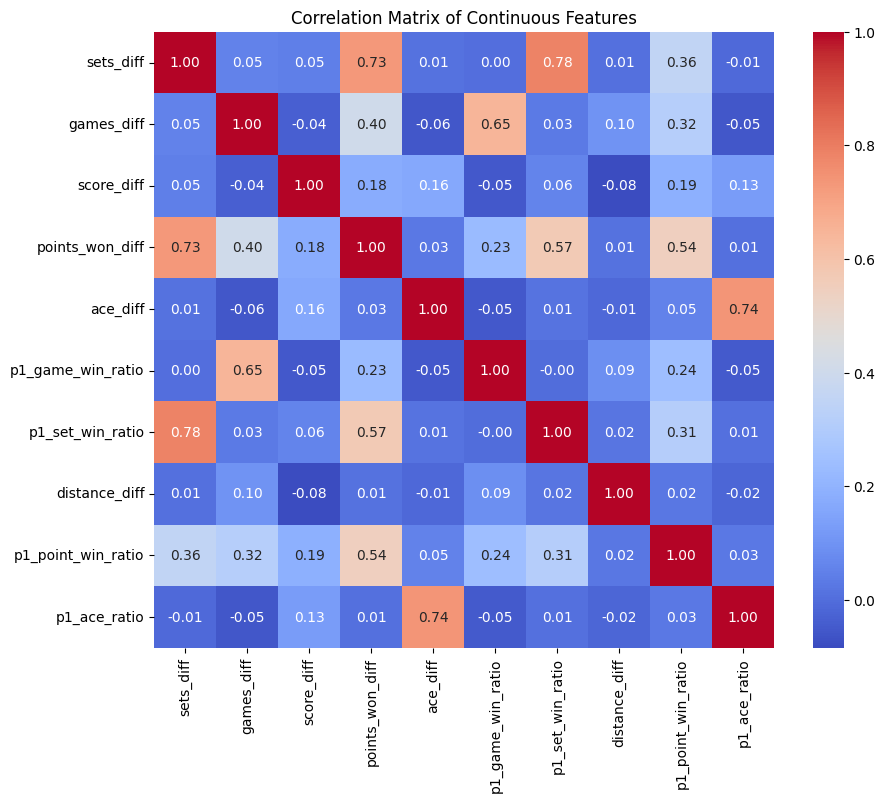

Strong positive correlations (> 0.7):
('sets_diff', 'points_won_diff', 0.7313390455677017)
('sets_diff', 'p1_set_win_ratio', 0.7849594838306218)
('ace_diff', 'p1_ace_ratio', 0.7376060119494077)

Strong negative correlations (< -0.7):


In [ ]:
# Tính ma trận tương quan
correlation_matrix = data[continuous_features].corr(method='pearson')  # Hoặc 'spearman'

# Vẽ heatmap để trực quan hóa
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Continuous Features')
plt.show()
strong_positive_corr = []
strong_negative_corr = []

for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        corr_value = correlation_matrix.iloc[i, j]
        if corr_value > 0.7:
            strong_positive_corr.append((correlation_matrix.index[i], correlation_matrix.columns[j], corr_value))
        elif corr_value < -0.7:
            strong_negative_corr.append((correlation_matrix.index[i], correlation_matrix.columns[j], corr_value))

print("Strong positive correlations (> 0.7):")
for pair in strong_positive_corr:
    print(pair)

print("\nStrong negative correlations (< -0.7):")
for pair in strong_negative_corr:
    print(pair)


Vì các biển có tương quan > 0.7 có độ phụ thuộc vào nhau rất lớn vì thế để giảm chiều dữ liệu, tránh đa cộng tuyến, đồng thời làm mô hình đơn giản hơn. Vì thế loại bỏ 1 vài biến sets_diff, ace_diff, 'p1_set_win_ratio'

In [ ]:
continuous_features = [
    'games_diff', 'score_diff', 'points_won_diff',
    'p1_game_win_ratio', 'distance_diff',
    'p1_point_win_ratio', 'p1_ace_ratio'

]

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ví dụ: Chọn các cột liên quan (thay bằng các cột của bạn)

# Tạo một DataFrame chỉ chứa các biến độc lập
X = data[continuous_features]

# Thêm một cột hằng số (cần thiết để tính VIF)
X = X.assign(const=1)

# Tính toán VIF cho từng biến
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


# Hiển thị kết quả
print(vif_data)


             Variable        VIF
0          games_diff   1.989487
1          score_diff   1.086948
2     points_won_diff   1.587724
3   p1_game_win_ratio   1.745745
4       distance_diff   1.017533
5  p1_point_win_ratio   1.478686
6        p1_ace_ratio   1.019719
7               const  71.379609


In [ ]:
# Tạo DataFrame kết hợp
data_train = pd.concat(
    [data[continuous_features], data[categorical_features], data['point_victor_p1']],
    axis=1
)

In [ ]:
from sklearn.model_selection import train_test_split
X = data_train.drop(columns=['point_victor_p1'])  # Biến độc lập
y = data_train['point_victor_p1']  # Biến mục tiêu

# Chia dữ liệu thành Train (60%), Validation (10%), Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Thí Nghiệm 1 :giữ nguyên các categorical_features không có ý nghĩa thống kê

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from tabulate import tabulate
import pandas as pd

# Lưu kết quả
results = []

# Danh sách mô hình
models = {
    "LGBM": LGBMClassifier(n_estimators=10, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.1, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=10, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=10, depth=10, learning_rate=0.1, verbose=0, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    logloss = log_loss(y_test, y_prob) if y_prob is not None else None
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Log Loss": logloss,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Định dạng bảng
results_table = tabulate(results_df, headers="keys", tablefmt="grid")

# Hiển thị bảng
print(results_table)


[LightGBM] [Info] Number of positive: 2669, number of negative: 2529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5198, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513467 -> initscore=0.053880
[LightGBM] [Info] Start training from score 0.053880


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+----+---------------+------------+----------+------------+-------------+----------+----------+
|    | Model         |   Accuracy |      AUC |   Log Loss |   Precision |   Recall |       F1 |
+====+===============+============+==========+============+=============+==========+==========+
|  0 | LGBM          |   0.74     | 0.82985  |   0.539035 |    0.713864 | 0.770701 | 0.741194 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  1 | XGBoost       |   0.712308 | 0.817642 |   0.536908 |    0.689552 | 0.735669 | 0.711864 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  2 | SVM           |   0.713846 | 0.783894 |   0.590046 |    0.703822 | 0.703822 | 0.703822 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  3 | MLP           |   0.703077 | 0.817476 |   0.502568 |    0.676385 | 0.738854 | 0.70624  |
+----+---------------+------------+-----

Thí nghiệm 2 : loại bỏ các categorical_features không có ý nghĩa thống kê

In [ ]:
categorical_features = [ 'server_is_p1']

In [ ]:
# Tạo DataFrame kết hợp
data_train = pd.concat(
    [data[continuous_features], data[categorical_features], data['point_victor_p1']],
    axis=1
)




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from tabulate import tabulate
import pandas as pd

# Lưu kết quả
results = []

# Danh sách mô hình
models = {
    "LGBM": LGBMClassifier(n_estimators=10, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.1, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=10, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=10, depth=10, learning_rate=0.1, verbose=0, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    logloss = log_loss(y_test, y_prob) if y_prob is not None else None
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Log Loss": logloss,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Định dạng bảng
results_table = tabulate(results_df, headers="keys", tablefmt="grid")

# Hiển thị bảng
print(results_table)


[LightGBM] [Info] Number of positive: 2669, number of negative: 2529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5198, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513467 -> initscore=0.053880
[LightGBM] [Info] Start training from score 0.053880


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+----+---------------+------------+----------+------------+-------------+----------+----------+
|    | Model         |   Accuracy |      AUC |   Log Loss |   Precision |   Recall |       F1 |
+====+===============+============+==========+============+=============+==========+==========+
|  0 | LGBM          |   0.74     | 0.82985  |   0.539035 |    0.713864 | 0.770701 | 0.741194 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  1 | XGBoost       |   0.712308 | 0.817642 |   0.536908 |    0.689552 | 0.735669 | 0.711864 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  2 | SVM           |   0.713846 | 0.783894 |   0.590046 |    0.703822 | 0.703822 | 0.703822 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  3 | MLP           |   0.703077 | 0.817476 |   0.502568 |    0.676385 | 0.738854 | 0.70624  |
+----+---------------+------------+-----

Từ đó cho thấy các thông số kia tuy kiểm định có chỉ số không ấn tượng nhưng lại đóng góp đáng kể cho hiệu suất mô hình vì vậy tiếp dưới đây tôi sẽ dùng thí nghiệm 1 để tiếp tục thí nghiệm 3


Thí nghiệm 3: Chuyện gì xảy ra nếu thêm momentum_temp từ model vào model dự đoán? Liệu nó tác động như thế nào?

In [ ]:
data2 = pd.read_csv('/content/predicted_momentum .csv')  # File chứa Momentum_temp
print(data2)

                 match_id  Ace  Distance_run  Error_rate_of_serve_no.1  \
0     2023-wimbledon-1301    0     -0.394420                       0.0   
1     2023-wimbledon-1301    0     -0.394616                       0.0   
2     2023-wimbledon-1301    0     -1.213620                       0.0   
3     2023-wimbledon-1301    0     -4.852655                       0.0   
4     2023-wimbledon-1301    1     -0.065010                       0.0   
...                   ...  ...           ...                       ...   
6493  2023-wimbledon-1701    0     -2.460307                       0.0   
6494  2023-wimbledon-1701    0     -2.044024                       0.0   
6495  2023-wimbledon-1701    0     -1.496252                       0.0   
6496  2023-wimbledon-1701    0     -0.552442                       0.0   
6497  2023-wimbledon-1701    0     -1.517872                       0.0   

      Lead_score  Net_pt_won  Rally_count  Server_pt  Speed_mph  Game_victor  \
0      -0.053137   -0.290596   

In [ ]:
categorical_features = [ 'serve_width', 'serve_depth', 'return_depth', 'double_fault_diff', 'server_is_p1','first_serve',]


In [ ]:
data_train['Momentum_temp'] = data2['Momentum_temp']

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from tabulate import tabulate
import pandas as pd

# Lưu kết quả
results = []

# Danh sách mô hình
models = {
    "LGBM": LGBMClassifier(n_estimators=10, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.1, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=10, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=10, depth=10, learning_rate=0.1, verbose=0, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    logloss = log_loss(y_test, y_prob) if y_prob is not None else None
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Log Loss": logloss,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Định dạng bảng
results_table = tabulate(results_df, headers="keys", tablefmt="grid")

# Hiển thị bảng
print(results_table)


[LightGBM] [Info] Number of positive: 2669, number of negative: 2529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5198, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513467 -> initscore=0.053880
[LightGBM] [Info] Start training from score 0.053880


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+----+---------------+------------+----------+------------+-------------+----------+----------+
|    | Model         |   Accuracy |      AUC |   Log Loss |   Precision |   Recall |       F1 |
+====+===============+============+==========+============+=============+==========+==========+
|  0 | LGBM          |   0.74     | 0.82985  |   0.539035 |    0.713864 | 0.770701 | 0.741194 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  1 | XGBoost       |   0.712308 | 0.817642 |   0.536908 |    0.689552 | 0.735669 | 0.711864 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  2 | SVM           |   0.713846 | 0.783894 |   0.590046 |    0.703822 | 0.703822 | 0.703822 |
+----+---------------+------------+----------+------------+-------------+----------+----------+
|  3 | MLP           |   0.703077 | 0.817476 |   0.502568 |    0.676385 | 0.738854 | 0.70624  |
+----+---------------+------------+-----

Qua đó, ta rút ra được 2 kết luận

1. Ta thấy được rằng khi cho biến momentum vào rõ ràng tác động đáng kể để mô hình cho thấy momentum đóng vai trò quan trọng và có ý nghĩa trong một trận đấu.

2. 3 mô hình hiệu quả nhất là LGBM,XGBoost,RandomForest.
vì thế để tạo mô hình tổng hợp dự đoán xác suất chiến thắng của người chơi qua từng point thì chúng tôi ban đầu tối ưu hóa từng model riêng để kiếm tham số tối ưu , sau đó chúng tôi kết hơp lại thành emsable model nhằm cải thiện hiệu quả

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Định nghĩa tham số cần tối ưu
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70]
}

# Khởi tạo GridSearch
lgbm_model = LGBMClassifier(random_state=42)
grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best parameters for LightGBM:", grid_lgbm.best_params_)
print("Best AUC for LightGBM:", grid_lgbm.best_score_)

# Lưu mô hình tốt nhất
best_lgbm = grid_lgbm.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 2669, number of negative: 2529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5198, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513467 -> initscore=0.053880
[LightGBM] [Info] Start training from score 0.053880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'num_leaves': 50}
Best AUC for LightGBM: 0.8253651007846899


In [ ]:
from xgboost import XGBClassifier

# Định nghĩa tham số cần tối ưu
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Khởi tạo GridSearch
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best AUC for XGBoost:", grid_xgb.best_score_)

# Lưu mô hình tốt nhất
best_xgb = grid_xgb.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:45:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
Best AUC for XGBoost: 0.8276784891872122


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from tabulate import tabulate
import pandas as pd

# Kết hợp các mô hình tốt nhất
ensemble_model = VotingClassifier(
    estimators=[
        ('LGBM', best_lgbm),
        ('XGBoost', best_xgb),
        ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42))
    ],
    voting='soft'  # Lấy xác suất dự đoán (soft voting)
)

# Huấn luyện VotingClassifier
ensemble_model.fit(X_train, y_train)

# Dự đoán và đánh giá



[LightGBM] [Info] Number of positive: 2669, number of negative: 2529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5198, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513467 -> initscore=0.053880
[LightGBM] [Info] Start training from score 0.053880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:56:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(max_depth=15, num_leaves=50,
                                             random_state=42)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gr...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
y_val_pred_ensemble = ensemble_model.predict(X_val)
y_val_prob_ensemble = ensemble_model.predict_proba(X_val)[:, 1]

# Tính toán các chỉ số cho Ensemble
ensemble_accuracy = accuracy_score(y_val, y_val_pred_ensemble)
ensemble_auc = roc_auc_score(y_val, y_val_prob_ensemble)
ensemble_logloss = log_loss(y_val, y_val_prob_ensemble)
ensemble_precision = precision_score(y_val, y_val_pred_ensemble)
ensemble_recall = recall_score(y_val, y_val_pred_ensemble)
ensemble_f1 = f1_score(y_val, y_val_pred_ensemble)
results1 = []
# Lưu kết quả mô hình Ensemble
ensemble_result = {
    "Model": "Ensemble Voting",
    "Accuracy": ensemble_accuracy,
    "AUC": ensemble_auc,
    "Log Loss": ensemble_logloss,
    "Precision": ensemble_precision,
    "Recall": ensemble_recall,
    "F1": ensemble_f1
}

# Thêm vào bảng kết quả
results1.append(ensemble_result)

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results1)

# Định dạng bảng
results_table = tabulate(results_df, headers="keys", tablefmt="grid")

# Hiển thị bảng
print(results_table)

+----+-----------------+------------+----------+------------+-------------+----------+----------+
|    | Model           |   Accuracy |      AUC |   Log Loss |   Precision |   Recall |       F1 |
+====+=================+============+==========+============+=============+==========+==========+
|  0 | Ensemble Voting |   0.747692 | 0.843964 |   0.474207 |    0.770774 |  0.76204 | 0.766382 |
+----+-----------------+------------+----------+------------+-------------+----------+----------+


[LightGBM] [Info] Number of positive: 2123, number of negative: 2035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 4158, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510582 -> initscore=0.042334
[LightGBM] [Info] Start training from score 0.042334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


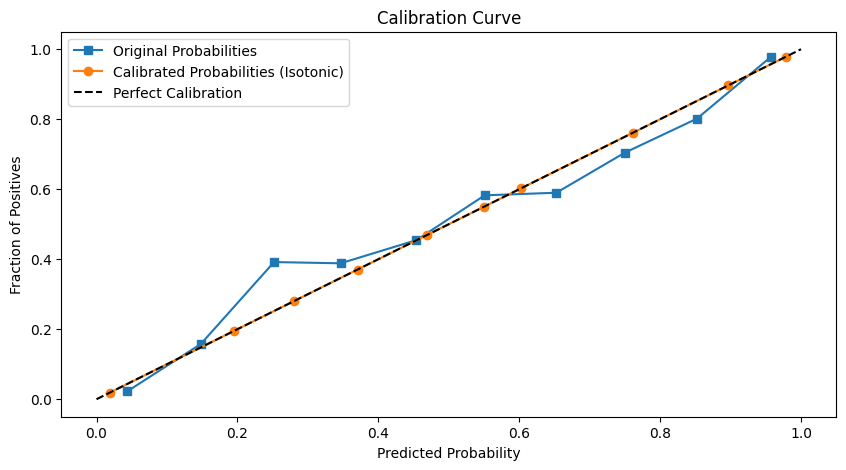

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import numpy as np

# Cross-validation
from sklearn.model_selection import train_test_split

X_train_iso, X_val_iso, y_train_iso, y_val_iso = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Huấn luyện mô hình XGBoost để tạo xác suất
ensemble_model.fit(X_train_iso, y_train_iso)
y_val_prob = ensemble_model.predict_proba(X_val_iso)[:, 1]

# Huấn luyện Isotonic Regression
isotonic = IsotonicRegression(out_of_bounds="clip")
isotonic.fit(y_val_prob, y_val_iso)

# Hiệu chỉnh xác suất
y_val_prob_calibrated = isotonic.predict(y_val_prob)

# So sánh Calibration Curve
prob_true, prob_pred = calibration_curve(y_val_iso, y_val_prob, n_bins=10)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val_iso, y_val_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 5))
plt.plot(prob_pred, prob_true, "s-", label="Original Probabilities")
plt.plot(prob_pred_calibrated, prob_true_calibrated, "o-", label="Calibrated Probabilities (Isotonic)")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

original_log_loss = log_loss(y_val_iso, y_val_prob)
calibrated_log_loss = log_loss(y_val_iso, y_val_prob_calibrated)

original_brier_score = brier_score_loss(y_val_iso, y_val_prob)
calibrated_brier_score = brier_score_loss(y_val_iso, y_val_prob_calibrated)

print(f"Original Log Loss: {original_log_loss:.4f}")
print(f"Calibrated Log Loss: {calibrated_log_loss:.4f}")
print(f"Original Brier Score: {original_brier_score:.4f}")
print(f"Calibrated Brier Score: {calibrated_brier_score:.4f}")


Original Log Loss: 0.4850
Calibrated Log Loss: 0.4638
Original Brier Score: 0.1649
Calibrated Brier Score: 0.1587


Log Loss:

Original Log Loss là 0.4850, sau hiệu chỉnh bằng Isotonic Regression giảm xuống còn 0.4638.
Việc giảm Log Loss cho thấy rằng mô hình sau hiệu chỉnh xác suất phù hợp hơn với thực tế.
Xác suất đầu ra đã giảm bớt sự khác biệt giữa giá trị dự đoán và nhãn thực tế, làm tăng độ tin cậy của mô hình trong việc dự đoán xác suất.
Brier Score:

Original Brier Score là 0.1649, sau hiệu chỉnh giảm xuống còn 0.1587.
Điều này chứng minh rằng dự đoán xác suất sau hiệu chỉnh không chỉ chính xác hơn mà còn gần hơn với nhãn thực tế trên toàn bộ tập dữ liệu.

Mục tiêu hiểu chỉnh là để  giúp các xác suất dự đoán phản ánh chính xác tần suất thực tế.

In [ ]:


from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score
from tabulate import tabulate


# Assuming X_train, y_train, X_val are defined from the previous code

# Cross-validation (example using a subset of X_train)
X_train_iso, X_val_iso, y_train_iso, y_val_iso = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# ... (previous code for defining and training ensemble_model) ...


# Huấn luyện mô hình để tạo xác suất (ensemble_model is assumed to be defined)
ensemble_model.fit(X_train_iso, y_train_iso)
y_val_prob = ensemble_model.predict_proba(X_val_iso)[:, 1]

# Huấn luyện Isotonic Regression
isotonic = IsotonicRegression(out_of_bounds="clip")
isotonic.fit(y_val_prob, y_val_iso)

# Hiệu chỉnh xác suất
y_val_prob_calibrated = isotonic.predict(y_val_prob)

# So sánh Calibration Curve
prob_true, prob_pred = calibration_curve(y_val_iso, y_val_prob, n_bins=10)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val_iso, y_val_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 5))
plt.plot(prob_pred, prob_true, "s-", label="Original Probabilities")
plt.plot(prob_pred_calibrated, prob_true_calibrated, "o-", label="Calibrated Probabilities (Isotonic)")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


original_log_loss = log_loss(y_val_iso, y_val_prob)
calibrated_log_loss = log_loss(y_val_iso, y_val_prob_calibrated)

original_brier_score = brier_score_loss(y_val_iso, y_val_prob)
calibrated_brier_score = brier_score_loss(y_val_iso, y_val_prob_calibrated)

print(f"Original Log Loss: {original_log_loss:.4f}")
print(f"Calibrated Log Loss: {calibrated_log_loss:.4f}")
print(f"Original Brier Score: {original_brier_score:.4f}")
print(f"Calibrated Brier Score: {calibrated_brier_score:.4f}")

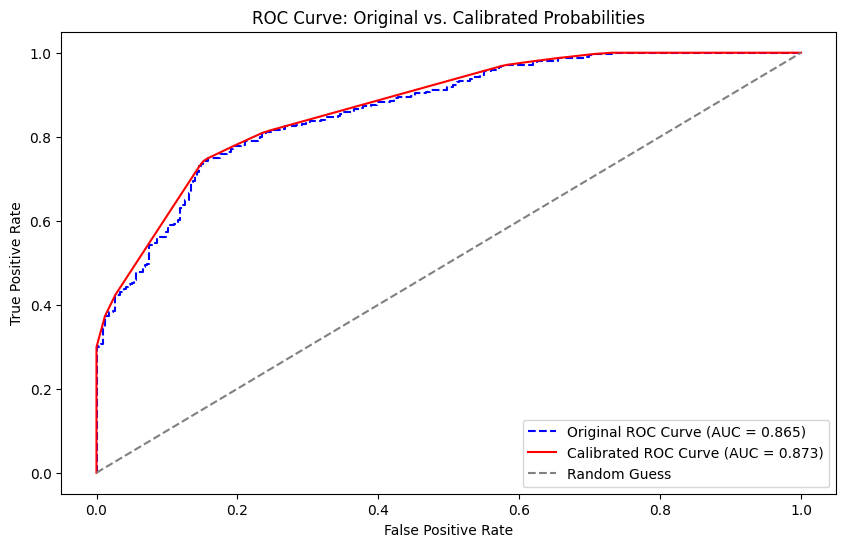

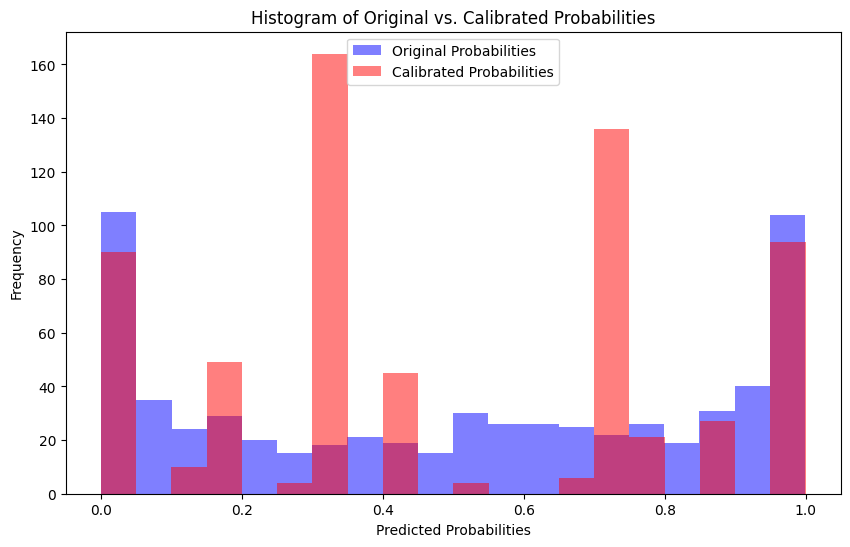

Original Log Loss: 0.4670
Calibrated Log Loss: 0.4163
Original Brier Score: 0.1561
Calibrated Brier Score: 0.1413


In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import IsotonicRegression
from sklearn.metrics import roc_curve, auc

# Dự đoán xác suất từ mô hình gốc (ví dụ XGBoost đã tinh chỉnh)
y_prob_original = best_xgb.predict_proba(X_test)[:, 1]

# Hiệu chỉnh xác suất bằng Isotonic Regression
isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(y_prob_original, y_test)
y_prob_calibrated = isotonic.predict(y_prob_original)

# ROC Curve (Trực quan hóa)
fpr_original, tpr_original, _ = roc_curve(y_test, y_prob_original)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_calibrated, tpr_calibrated, _ = roc_curve(y_test, y_prob_calibrated)
roc_auc_calibrated = auc(fpr_calibrated, tpr_calibrated)

plt.figure(figsize=(10, 6))
plt.plot(fpr_original, tpr_original, label=f"Original ROC Curve (AUC = {roc_auc_original:.3f})", linestyle='--', color='blue')
plt.plot(fpr_calibrated, tpr_calibrated, label=f"Calibrated ROC Curve (AUC = {roc_auc_calibrated:.3f})", color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Original vs. Calibrated Probabilities")
plt.legend(loc="lower right")
plt.show()

# Histogram (Trực quan hóa xác suất)
plt.figure(figsize=(10, 6))
plt.hist(y_prob_original, bins=20, alpha=0.5, label="Original Probabilities", color="blue")
plt.hist(y_prob_calibrated, bins=20, alpha=0.5, label="Calibrated Probabilities", color="red")
plt.xlabel("Predicted Probabilities")
plt.ylabel("Frequency")
plt.title("Histogram of Original vs. Calibrated Probabilities")
plt.legend(loc="upper center")
plt.show()

# Kết quả Log Loss và Brier Score
from sklearn.metrics import log_loss, brier_score_loss

log_loss_original = log_loss(y_test, y_prob_original)
log_loss_calibrated = log_loss(y_test, y_prob_calibrated)
brier_score_original = brier_score_loss(y_test, y_prob_original)
brier_score_calibrated = brier_score_loss(y_test, y_prob_calibrated)

print(f"Original Log Loss: {log_loss_original:.4f}")
print(f"Calibrated Log Loss: {log_loss_calibrated:.4f}")
print(f"Original Brier Score: {brier_score_original:.4f}")
print(f"Calibrated Brier Score: {brier_score_calibrated:.4f}")
